In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
# import data
data = pd.read_csv("Titanic Dataset\\train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# delete unnecessary columns
del data['PassengerId']
del data['Name']
del data['Ticket']
del data['Cabin']

# drop null values
data = data.dropna(subset=['Age'])

In [4]:
# one-hot endode decrete columns
sex = data['Sex']
pclass = data['Pclass']
embark = data['Embarked']
sex_hot = pd.get_dummies(sex, prefix='sex')
pclass_hot = pd.get_dummies(pclass, prefix='class')
embark_hot = pd.get_dummies(embark, prefix='embarked')

data = pd.concat([data, sex_hot, pclass_hot, embark_hot],axis=1)

data = data.drop(['Sex', 'Pclass', 'Embarked'], axis=1)

data.head()

,Survived,Age,SibSp,Parch,Fare,sex_female,sex_male,class_1,class_2,class_3,embarked_C,embarked_Q,embarked_S
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,1,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [5]:
feats = data.iloc[:,1:]
labels = data.iloc[:,0]

# normalize
feats = (feats-feats.mean())/feats.std()

# add bias term
feats['intercept'] = 1
cols = feats.columns.tolist()
cols = cols[-1:] + cols[:-1]
feats = feats[cols]

# split into train/val/test
x_train, x_val, y_train, y_val = train_test_split(feats, labels, test_size=150)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=150)

print (x_train.shape, x_val.shape, x_test.shape)

(414, 13) (150, 13) (150, 13)


In [6]:
# predition function that returns probabilities
def predict_prob(x, w):
    z = x @ w.T
    return 1/(1 + np.exp(-z))

In [7]:
# prediction function that returns predictions (0 or 1)
def predict(x, w, thresh=0.5):
    return predict_prob(x, w) >= thresh

In [8]:
# SGD function that returns computed coefficients
def SGD(x, y, rate, lam, epoch):
    
    # initialize weight vector
    w = np.atleast_2d(np.ones(x_train.shape[1]))
    likes = []
    
    # iterate num epochs
    for ii in range(epoch):
        yhat = predict_prob(x, w)
        likelihood = (y*np.log(yhat.flatten()) + (1-np.array(y))*np.log(1-yhat.flatten())).mean()
        likes.append(likelihood)
        grad = ((yhat.T - y) @ x)/len(y) - lam*w
        w = w - rate*grad
        
    return w, likes

In [9]:
# logistic regression function to train and test the model
def log_reg(x_train, y_train, x_test, y_test, rate, epoch, l2=False):
    
    if l2:
        lam = 0.01
    else:
        lam = 0
        
    coef, likes = SGD(x_train, y_train, rate, lam, epoch)  
    yhat = predict(x_test, coef)
    acc = (yhat.flatten() == y_test).mean()
    
    return acc, likes

In [10]:
rate = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75]
epoch = 300
acc_list = []

for ii in range(len(rate)):
    acc, _ = log_reg(x_train, y_train.tolist(), x_val, y_val, rate[ii], epoch)
    print (round(acc,2), "with learning rate", rate[ii])
    acc_list.append(acc)

best_rate = acc_list.index(max(acc_list))
acc, likes1 = log_reg(x_train, y_train.tolist(), x_test, y_test, rate[best_rate], epoch)
print ("----------------")
print ("test accuracy: ", round(acc*100,4))

acc, likes2 = log_reg(x_train, y_train.tolist(), x_test, y_test, rate[best_rate], epoch, l2=True)
print ("----------------")
print ("test accuracy with l2: ", round(acc*100,4))

0.63 with learning rate 0.0001
0.64 with learning rate 0.001
0.68 with learning rate 0.01
0.77 with learning rate 0.1
0.77 with learning rate 0.5
0.77 with learning rate 0.75
----------------
test accuracy:  73.3333
----------------
test accuracy with l2:  72.6667


In [11]:
clf = LogisticRegression()
clf.fit(x_train, y_train)
acc = round(clf.score(x_test, y_test)*100,2)
print ("test accuracy from sklearn (with l2): ", acc)

test accuracy from sklearn (with l2):  72.67


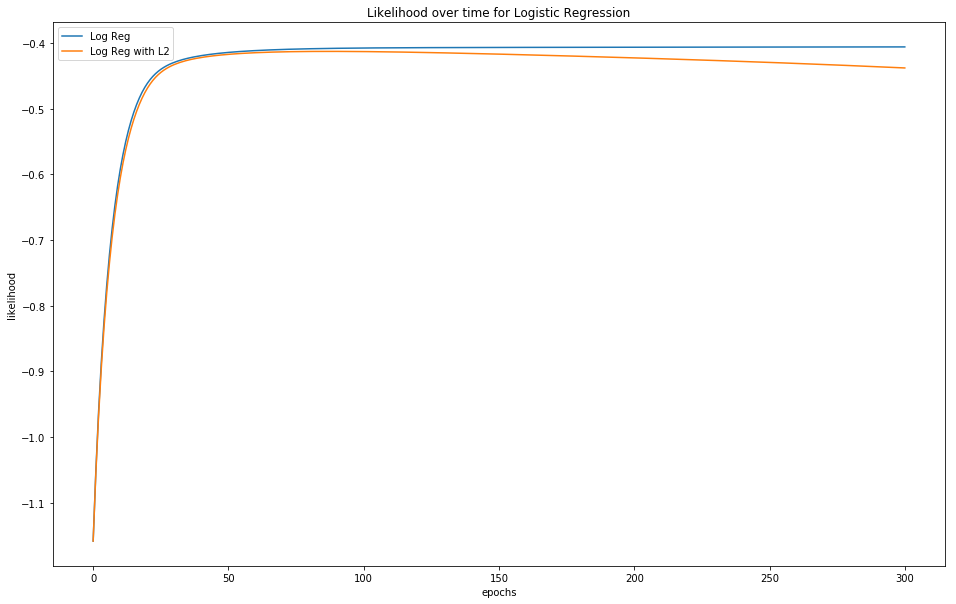

In [12]:
x = np.linspace(0,epoch,epoch)

fig, ax = plt.subplots(figsize=[16,10])
ax.plot(x, likes1, label='Log Reg')
ax.plot(x, likes2, label='Log Reg with L2')

plt.xlabel('epochs')
plt.ylabel('likelihood')
plt.title('Likelihood over time for Logistic Regression')
plt.legend()
plt.show()